# Data Synthesis and Header Separation

In [1]:
# %%capture
## All my imports
print("Versions")
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import os
# Text Stuff
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# nltk.download("stopwords")

Versions
Pandas: 1.2.1
Numpy: 1.19.2


In [29]:
paths = {
    "heading": '../data/headings/heading_counts_clean.csv',
    'scraping': '../data/scraping_results/',
    'merged': '../data/merged_df.csv', # This is where to store the merged dataframe
    'visualizations': "../visualizations" # Path to store visualizations
}

# Data Ingestion and Wrangling (ETL)

Before you go on with 1 and 2, make sure you run ```indeed.py``` and ```linkedin.py```to create the data for us to use here in the "scraping_results" folder.

# 1. Indeed

In [2]:
# Ingesting the data from the Indeed scraping


def ingest_indeed(path = path['scraping']):
    ''' 
    Inputs: 
    ------
    path : string
        Path of the files where the scraped data (results from the indeed.py
    goes to)   
    
    Outputs: 
    --------
    The final indeed dataframe with just "Title", "Description", and "Location"
    '''

    indeed = pd.DataFrame(columns = ['date', 'details', 'location', 'summary', 
                                     'title', 'url', 'rating'])
    
    json_files = [i for i in os.listdir(path) if 'data.json' in i]
    for file in json_files:
        indeed = indeed.append(pd.read_json(path + file))

    # Combining the Details and Summary section from the indeed into - also adding location 
    # ONE column
    def combine(df):
        ''' 
        Combining the details and summary section
        Bonus: Attaching the location info
        '''
        location = []
        full = []

        for i, j, loc in zip(df['details'], df['summary'], df['location']):
            full.append(i + '\n' + j)

            loc = loc.lower()

            if "san francisco" in loc or "sf" in loc:
                location.append("san francisco")
            elif "new york" in loc or "ny" in loc:
                location.append("new york")
            elif "texas" in loc or "tx" in loc:
                location.append("texas")
            else:
                location.append("other")

        return pd.DataFrame({'Title': df['title'], 'Description': full, 
                            'Location': location})

    # Narrowing down to the parts we want and updating the changes into the 
    # indeed object
    indeed = combine(indeed)
    
    return indeed

In [3]:
indeed = ingest_indeed()
indeed.head()

,Title,Description,Location
0,Data Scientist,Data Scientist\n\nChange Research is innovatin...,san francisco
1,Data Science-Consultant,Key skills required for the job are: n Data Sc...,san francisco
2,Data Scientist,"This role applies skills as a seasoned, experi...",san francisco
3,Intern: Data Scientist,Position Overview:\nThe Climate Corporation’s ...,san francisco
4,Ads Data Scientist,eBay Inc. is a global commerce leader that con...,san francisco


In [4]:
indeed['Location'].value_counts()

new york         756
san francisco    536
texas            195
other            183
Name: Location, dtype: int64

In [5]:
indeed.shape

(1670, 3)

# 2. LinkedIn

In [6]:
def ingest_linkedin(path = paths['scraping']):
    '''
    Ingesting the data from the LinkedIn scraping, and aggregating 
    them all to one dataframe
    '''

    linkedin = pd.DataFrame(columns = ["Title", "Description", "Company Name", "Location", "Industry", 
                                       "Job Functions", "Time Posted", "Employment Type", "Applicant Count"])

    for file in [i for i in os.listdir(path) if 'job_scraping' in i]:
        linkedin = linkedin.append(pd.read_csv(path + file))


    # Location simplification
    location = []
    for loc in linkedin['Location']:

        loc = loc.lower()

        if "san francisco" in loc or "sf" in loc:
            location.append("san francisco")
        elif "new york" in loc or "ny" in loc:
            location.append("new york")
        elif "texas" in loc or "tx" in loc:
            location.append("texas")
        else:
            location.append("other")

    linkedin['Location'] = location

    linkedin.drop('Unnamed: 0', axis = 1, inplace = True)
    
    return linkedin

In [7]:
linkedin = ingest_linkedin()

linkedin.head()

,Title,Description,Company Name,Location,Industry,Job Functions,Time Posted,Employment Type,Applicant Count
0,Data Scientist,\n\n\nThis position can be based remotely anyw...,Linde,new york,Oil & Energy,Information Technology,2 weeks ago,Entry level,199 applicants
1,Data Scientist,\n\nSummary\n \nImagine what you could do here...,Apple,texas,Consumer Electronics,Engineering,12 hours ago,Full-time,12 applicants
2,Data Scientist,\nLead analytics and measurement efforts for s...,Merkle,other,Marketing & Advertising,Strategy/Planning,5 days ago,Mid-Senior level,54 applicants
3,"Data Scientist, Product Analytics","\nAbout Gusto\n\nGusto is a modern, online peo...",Gusto,other,Computer Software,Internet,21 hours ago,Entry level,27 applicants
4,"Search Data Scientist, Apple App Store - Austin","\n\nSummary\n \nAt Apple, new ideas have a way...",Apple,texas,Consumer Electronics,Engineering,21 hours ago,Full-time,7 applicants


In [8]:
linkedin['Location'].value_counts()

other            20
texas             7
new york          5
san francisco     1
Name: Location, dtype: int64

# Merging
Now we want to combine both the indeed and LinkedIn data into one dataframe containing very similar formats.

In [9]:
merged = pd.concat([linkedin[['Title', 'Description', 'Location']], indeed])

merged['Title'].value_counts()[:20]

Data Scientist                                                  93
Data Analyst                                                    70
Senior Data Scientist                                           49
Senior Data Analyst                                             48
Business Analyst                                                39
Machine Learning Engineer                                       19
Business Intelligence Analyst                                   16
Lead Data Scientist                                             10
Product Data Analyst                                             9
Quantitative Researcher                                          8
Data Engineer                                                    7
Statistician                                                     6
Principal Data Scientist                                         6
Senior Marketing Data Analyst                                    6
Data Science Intern                                           

In [10]:
def add_label(df):
    # Now I add a label based on the job title
    titles = []
    for title in df['Title']:
        title = title.lower()
        if "data analyst" in title:
            titles.append("data analyst")
        elif "data scientist" in title:
            titles.append("data scientist")
        elif "business analyst" in title:
            titles.append("business anlayst")
        elif "machine learning" in title:
            titles.append("machine learning")
        elif "data engineer" in title:
            titles.append("data engineer")
        else:
            titles.append("other")
    df["Job Title"] = titles
    df.drop("Title", axis = 1, inplace = True)
    
    return df

merged = add_label(merged)

TODO: Compare business intelligence analyst to data analyst? See if they look similar enough for us to put together. Same for MLE and DS.

In [11]:
merged.head()

,Description,Location,Job Title
0,\n\n\nThis position can be based remotely anyw...,new york,data scientist
1,\n\nSummary\n \nImagine what you could do here...,texas,data scientist
2,\nLead analytics and measurement efforts for s...,other,data scientist
3,"\nAbout Gusto\n\nGusto is a modern, online peo...",other,data scientist
4,"\n\nSummary\n \nAt Apple, new ideas have a way...",texas,data scientist


In [12]:
# Saving it to a csv file
merged.to_csv(paths['merged'])

# Wordcloud Initial EDA
I also implemented this as a class in the` __init__.py of the research module I built for this project.

In [28]:
# NLTK stopwords
stop = stopwords.words("english") + ["data"]
# Manual stopwords
my_stop = ["and", "to", "the", "of", "with", "data"]

In [49]:
# Wordcloud
from wordcloud import WordCloud

def to_wcdf(seq, stopwords):
    ''' Converts
    Params:
    ------
    data: Pandas series/list of the corpus
    
    Returns:
    -------
    counts: dataframe with word counts
    '''
    # Initializing the Count Vectorizer, exluding words 
    # that appear less than 5 times
    bagofwords = CountVectorizer(min_df = 5, stop_words = stop)
    words = bagofwords.fit_transform(seq)
    counts = pd.DataFrame(columns = bagofwords.get_feature_names(), data = words.toarray())
    
    return counts

# Combining entire description column into a single string

def word_cloud(seq, output_path = paths['visualizations']):
    ''' Creates a word cloud visualization
    Params:
    -------
    seq
        List or Pandas series of words
    output_path
        The path to export the visualization to
    '''
    combined_corpus = ""
    for i in seq:
        combined_corpus += '\n' + i

    # Generate word cloud visualization
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = stop).generate(combined_corpus)

    # Visualizing with a bar graph
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
 
    
def visualize_counts(seq, n = 30, stopwords = stop):
    '''
    Inputs:
    -------
    n: the top n words to visualize and include in the plot
    
    '''
    counts = to_wcdf(seq, stop)

    # Getting word frequencies
    frequencies = counts.sum().sort_values(ascending = False)[1:n]

    # Visualizing
    plt.figure(figsize = (16, 5))
    sns.barplot(frequencies.index, frequencies.values, palette = 'inferno')
    plt.xticks(rotation = 90)
    plt.title(f"Top {n} Most Frequent Words in the Corpus Inside")
    plt.show()


/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


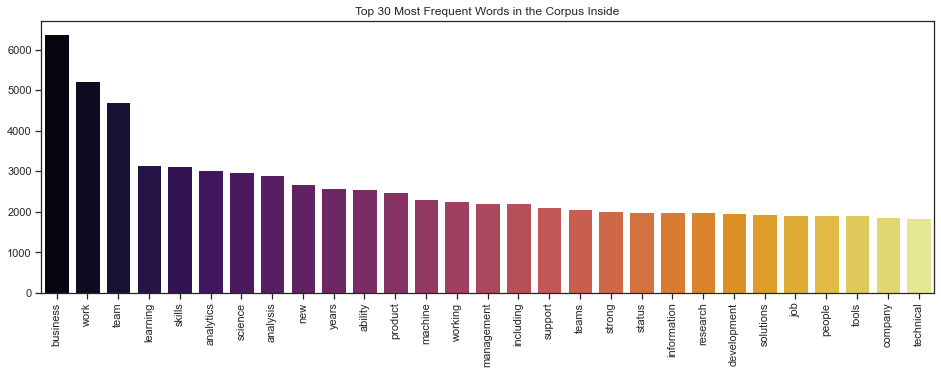

In [50]:
visualize_counts(merged['Description'])

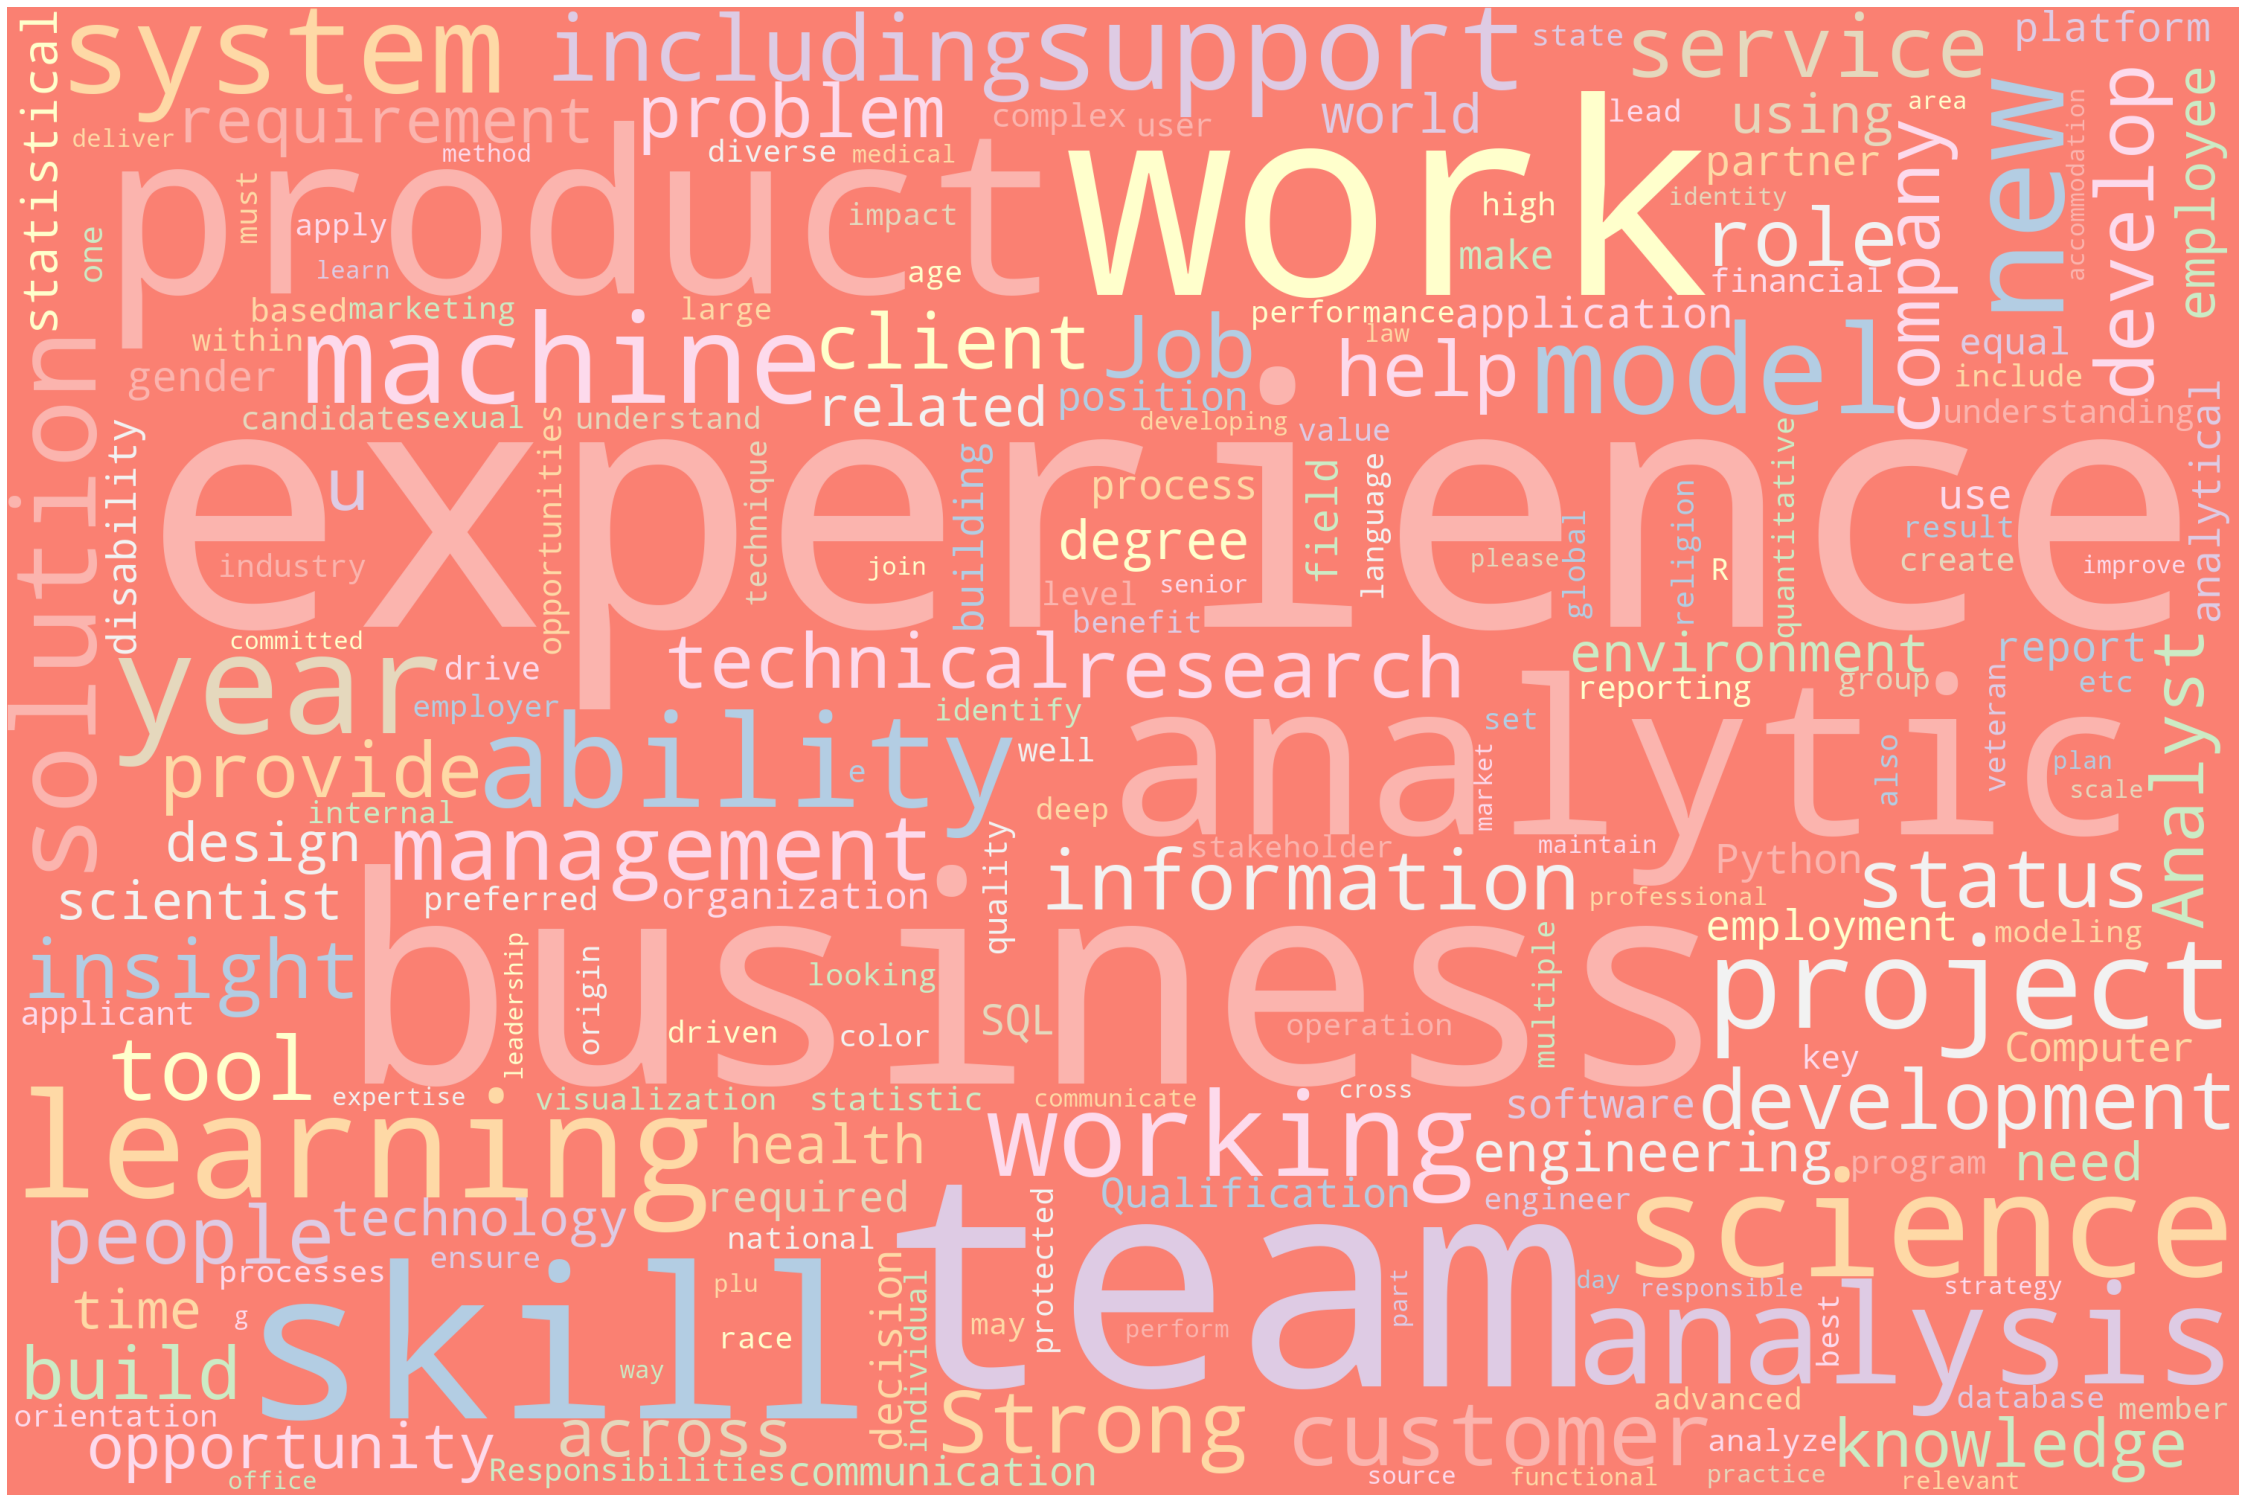

In [45]:
word_cloud(merged['Description'])

Nice! Now we can see the top words in a visually nice way with wordclouds. 

# Header Seperation

Here, we wish to remove the header and make it in it's own qualitative variable. In order to do this, we have to think: what constitutes a header? Here are some characteristics:

* It usually is much shorter in token length
* It usually contains a certain set of "headliny" words

Based on these two features alone, I bet that we can code up this separation.

If this doesn't work, we can take a very likely set of the headliny words, then for every headliny word seen, we can increase the probability that it would be a headliny word. I have a feeling something simple like Naive Bayes classifier for headliny word would already be very accurate.

For this header separation, all we are doing is working on the "Description" column.

In [14]:
# Unit testing check function

vocab = ["Job", "Location", "Qualifications", "Perks", "Impact", "About", "Description", 
         "Compensation", "Why", "Summary", "Skills", "Preferred", "Who", "Requirements",
        "Opportunity"]
vocab = [i.lower() for i in vocab]

def check(sent, vocab):
    ''' Checks if the heading vocab is inside the sentence you feed it in '''
    contains = False
    for word in vocab:
        evaluate = [word in i for i in sent]
        if True in evaluate:
            contains = True
            break
    return contains

a = ['This', 'position', 'can', 'be', 'based', 'remotely', 'anywhere', 'in', 'the', 'USA,', 'or', 'based', 'in', 'Tonawanda,', 'NY.']
a = [i.lower() for i in a]

check(a, vocab)

False

Let's start small with just one row. Then if it works, we will move on to the rest of the dataset!

In [15]:
# These are a set of words that I want to require in order for the line to be a heading classification
vocab = ["Job", "Location", "Qualifications", "Perks", "Impact", "About", "Description", 
         "Compensation", "Why", "Summary", "Skills", "Preferred", "Who", "Requirements",
        "Opportunity", "Salary", "Impact", "Work", "Join", "Technical", "Required",
        "Overview", "What", "Benefits", "Vision", "Mission", "Responsibilities",
        'Experience', "Need", "Forward", "Love", "Characteristics", "Desired", "Career",
        "Notices", 'Education']
vocab = [i.lower() for i in vocab]

# Example - we are just testing on one of the description rows
test  = merged['Description'].iloc[0]

def header_separation(desc):
    ''' This function constantly flips between list methods and string methods to do 
    the calculations.
    
    Inputs: 
    -------
    Job Description for ONE entry
    Outputs: A dataframe with Heading as a column, and Heading text mapped to it in another
    
    
    '''
    
    def check(sent, vocab):
        ''' Checks if the heading vocab is inside the sentence you feed it in '''
        contains = False
        for word in vocab:
            evaluate = [word in i for i in sent]
            if True in evaluate:
                contains = True
                break
        return contains
    
    # Separating it by new line and making it a list of lists.
    desc = [i.split() for i in desc.split('\n')]
    
    # Removing all empty lists (entries)
    while [] in desc: desc.remove([]) 
        
    # Prepending: Designating the first header to be called 'Entry'
    headers = ["Entry"]
    master_content = []
    current_content = []

    # Code to classify header = If the line has less than 6 tokens, I consider it a header.
    # Then I take everything in between headers as the current header content
    for i in desc:
        # Checking if the heading vocab is inside the line
        lowered_sent = [e.lower() for e in i]
        if len(i) < 6 and check(lowered_sent, vocab):
#             print("============================================================\n")
#             print(current_content)
            master_content.append([" ".join(i) for i in current_content])
            current_content.clear()
            current_header = " ".join(i)
            headers.append(current_header)
        else:
            current_content.append(i)
            
    # Adjusting for the prepend to add the last entry manually
    master_content.append([" ".join(i) for i in current_content])
    
    # Need to convert from list to just a string
    stringed_master_content = []
    
    # Converting the content from a list to just a string
    for i in master_content:
        if len(i) >= 1:
            stringed_master_content.append(i[0])
        else:
            stringed_master_content.append('')
    
    # Using extracted dictionary to create a new dataframe of Heading and its text
    output = pd.DataFrame({"Heading": headers, "Heading Text": stringed_master_content})
        
    return output


output = header_separation(test)

In [16]:
output

,Heading,Heading Text
0,Entry,This position can be based remotely anywhere i...
1,Position Summary,This is a unique opportunity to collaborate wi...
2,Desired Skills and Experience,
3,Basic Requirements,"BS degree in Industrial Engineering, Chemical ..."
4,Preferred Qualifications,"MS or higher degree in Industrial Engineering,..."


# Using Header Separation on Rest of the Dataset

In [17]:
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

def transform(line):
    ''' This function is used to remove the punctuations from the dataset '''
    # Removing punctuations
    no_punct = ""
    for char in line:
        if char not in punctuations:
            no_punct = no_punct + char
            
    return no_punct.lower()


a = 'Requirements: LOVIE;;'
transform(a)

'requirements lovie'

Great! Now that we successfully got the dataframe of headings for one job entry, we need to try to expand it on the rest of the dataset.

Here's a useful article on Python vectorization, which is preferred over iterating through the dataframe for its speed: https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#essential-basic-functionality

In [18]:
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

def transform(line):
    ''' This function is used to remove the punctuations from the dataset '''
    # Removing punctuations
    no_punct = ""
    for char in line:
        if char not in punctuations:
            no_punct = no_punct + char

    return no_punct.lower()


def attach_headings(df, path_to_labels = '../data/headings/heading_labels.csv', 
                    save_to_path = "../data/merged_headings_df.csv"):
    '''
    Now for each job posting, based on the ID, I will create new 
    dataframe containing the headings and mapping it to the ID
    '''

    def synthesize_headings(df):
        ''' 
        Inputs: 
        -------
        Job descriptions dataframe 
        
        Outputs:
        -------
        Original dataframe with ID column, Heading synthesized dataframe
        '''

        # Creating a unique ID for the df
        df['ID'] = np.arange(df.shape[0])

        heading = pd.DataFrame(columns = ["ID", "Heading", "Heading Text"])
        job_id = []

        for i in range(len(df)):
            # Mini header represents the headings dataframe for ONE given row in the Linkedin dataframe
            # The columns it has is Heading and Heading Text
            mini_header = header_separation(df['Description'].iloc[i])
            heading = pd.concat([heading, mini_header])

            # Manually creating the Job ID row based on the number of rows that results in the mini heading df
            job_id += [df['ID'].iloc[i]] * mini_header.shape[0]

        # Adding Job ID Column into the final heading dataframe
        heading['ID'] = job_id

        return df, heading

    # Merged will be the merged dataframe with the ID column attached, 
    merged, headings = synthesize_headings(df)

    # Cleaning the headings column of the merged headings dataframe
    headings['Heading'] = headings['Heading'].apply(transform)

    # Now adding a label onto based on Professor Sandra's suggestion
    heading_labels = pd.read_csv(path_to_labels)

    headings_df = pd.merge(headings, heading_labels, left_on = "Heading", right_on = "Heading Title", how = "inner")
    headings_df.drop(['Unnamed: 0', 'Unnamed: 4', "Heading"], axis = 1, inplace = True)
    
    # Exporting to csv
    headings_df.to_csv(save_to_path)
    
    return headings_df

In [19]:
headings_df = attach_headings(merged) 
headings_df.head()

,ID,Heading Text,Heading Title,Frequency,Person/Job/Org/None
0,0,This is a unique opportunity to collaborate wi...,position summary,56,Job
1,43,We are looking for a full time Data Scientist ...,position summary,56,Job
2,157,The Senior Data Analyst is responsible for ana...,position summary,56,Job
3,176,In this role you'll be working on a team desig...,position summary,56,Job
4,183,The Senior Data Analyst is responsible for ana...,position summary,56,Job


In [25]:
def heading_counts(headings_df, 
                   output_path = paths['heading']):
    ''' Just to get a cleaned version of the heading counts.
    '''
    # Exporting heading counts
    heading_counts = headings_df['Heading Title'].value_counts()
    heading_counts = pd.DataFrame({"Heading Title": 
            heading_counts.index, "Frequency": heading_counts.values})
    
    # Taking out "data" token as that is the most frequent word
    heading_counts.iloc[1:, :].to_csv(output_path)

    # Converting all to lowercase and aggregating
    heading_counts['Heading Title'] = heading_counts['Heading Title'].apply(transform)
    
    headings_df = heading_counts.groupby("Heading Title").sum()\
    .sort_values("Frequency", ascending = False).reset_index().iloc[1:,:]
    
    headings_df.to_csv(output_path)

    return headings_df

In [26]:
heading_counts(headings_df)

,Heading Title,Frequency
1,qualifications,358
2,job description,211
3,location,190
4,preferred qualifications,166
5,requirements,145
...,...,...
1631,peerdriven workshops,1
1632,perform other duties as required,1
1633,performance requirements,1
1634,excellent data analysis skills,1
